# Assignment

In [4]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
import numpy.matlib
import pandas as pd
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
import random

size_board = 4
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [54]:
##  Define functions

def EpsilonGreedy_Policy(Qvalues, epsilon, allowed_a):
    
    N_a=np.shape(Qvalues)[0]
    a = list(range(0, N_a))
    a = [i for idx, i in enumerate(a) if allowed_a[idx]]
    Qvalues = [i for idx, i in enumerate(Qvalues) if allowed_a[idx]]

    rand_value=np.random.uniform(0,1)
 ## epsilon is probability that we go random
    rand_a=rand_value<epsilon

    if rand_a==True:
        
        a = random.choice(a)

    else:
        idx=np.argmax(Qvalues)
        a = a[idx]
            
    return a


def ComputeQvalues(W1, W2, bias_W1, bias_W2, X, hiddenactivfunction , outeractivfunction):
    ## Qvalues=np.matmul(W2, np.matmul(W1,X)) ## this is direct computation of hidden layer and then output layer, without applying any non linear activation function
    ## below is a better solution:
    # Neural activation: input layer -> hidden layer
    H1 = np.matmul(W1,X)+bias_W1 ## make sure that bias_W1 does not need to be transposed
    # if hidden activ function is given:
    if (hiddenactivfunction == 1):
        H1 = np.round(1/(1+np.exp(-H1)), 5)
        
    Qvalues = np.matmul(W2,H1) + bias_W2
    
    #if outer activ function is given
    if (outeractivfunction == 1):
        Qvalues = np.round(1/(1+np.exp(- Qvalues)), 5)

    return Qvalues


In [67]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()



N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES



## INITALISE YOUR NEURAL NETWORK... Here weights from input to hidden layer and from the hidden layer to output layer are initialized
W1=np.random.randn(N_h,N_in)/1000
W2=np.random.randn(N_a,N_h)/1000


##W1 = np.divide(W1,np.matlib.repmat(np.sum(W1,1)[:,None],1,N_in))
##W2 = np.divide(W2,np.matlib.repmat(np.sum(W2,1)[:,None],1,N_h))


bias_W1 = np.zeros((N_h,))

bias_W2 = np.zeros((N_a,))



# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.1     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 1000 # THE NUMBER OF GAMES TO BE PLAYED 

hiddenactivfunction = 1
outeractivfunction = 0

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


In [ ]:
# SARSA

for n in range(N_episodes):
    S,X,allowed_a=env.Initialise_game()
   
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
                               
    Qvalues = ComputeQvalues(W1, W2, bias_W1, bias_W2, X, hiddenactivfunction , outeractivfunction)

    
    a=EpsilonGreedy_Policy(Qvalues,epsilon_f, allowed_a)
    
    while (Done==0 and i<50):                           ## START THE EPISODE
       
        Qvalues = ComputeQvalues(W1, W2, bias_W1, bias_W2, X, hiddenactivfunction , outeractivfunction)   
        S_next, X_next,allowed_a_next,R,Done=env.OneStep(a)
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            R_save[n,]=np.copy(R)
            N_moves_save[n,]=i
            
            dEdQ=R-Qvalues[a]
           
          
            ## update W2 and B2   
            dQdY = 1  
            if outeractivfunction == 1:
                    dYdQ = Qvalues[a]*(1-Qvalues[a])
                    
          
            H = np.matmul(W1,X) + bias_W1
            if hiddenactivfunction == 1:
                     H = np.round(1/(1+np.exp(-H)), 5)
            dYdW = H
    
        
            W2[a,:]=W2[a,:]+eta*dEdQ*dQdY*dYdW
            bias_W2[a]=bias_W2[a]+eta*dEdQ*dQdY
            
            
             ## update W1 and B1 after W2 and B2 were updated
        
            if hiddenactivfunction == 1:
                dYdZ =  (W2[a,:].reshape(1, 200) * H*(1-H).reshape(1, 200)).reshape(200,1)
            else:
                 dYdZ =  W2[a,:].reshape(200, 1)
        
            dZDW = X.reshape(1, 58)        
            W1[:,:]=W1[:,:]+ eta*dEdQ*dQdY*dYdZ*dZDW 
            bias_W1=bias_W1+ eta*dEdQ*dQdY*dYdZ.reshape(200,) 
            
            break
        
       
  
        
        
        # IF THE EPISODE IS NOT OVER...
        else:
            
            Qvalues1=ComputeQvalues(W1, W2, bias_W1, bias_W2, X_next, hiddenactivfunction , outeractivfunction)

            a1=EpsilonGreedy_Policy(Qvalues1,epsilon_f, allowed_a_next)

            # Compute the delta
            dEdQ=R+gamma*Qvalues1[a1]- Qvalues[a]
                  
            ## update W2 and B2   
            dQdY = 1  
            if outeractivfunction == 1:
                    dYdQ = Qvalues[a]*(1-Qvalues[a])
                    
          
            H = np.matmul(W1,X) + bias_W1
            if hiddenactivfunction == 1:
                     H = np.round(1/(1+np.exp(-H)), 5)
            dYdW = H
    
        
            W2[a,:]=   W2[a,:]+   eta*dEdQ*dQdY*dYdW
            bias_W2[a]=bias_W2[a]+eta*dEdQ*dQdY
            
            
             ## update W1 and B1 after W2 and B2 were updated
        
            if hiddenactivfunction == 1:
                dYdZ =  (W2[a,:].reshape(1, 200) * H*(1-H).reshape(1, 200)).reshape(200,1)
            else:
                 dYdZ =  W2[a,:].reshape(200, 1)
        
            dZDW = X.reshape(1, 58)        
            W1[:,:]=W1[:,:]+ eta*dEdQ*dQdY*dYdZ*dZDW 
            bias_W1=bias_W1+ eta*dEdQ*dQdY*dYdZ.reshape(200,) 
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        a = np.copy(a1)

        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

        
        
    
    

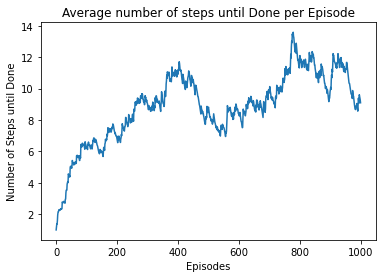

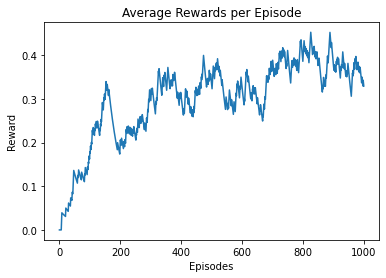

In [66]:
# Plot the performance
N_moves_save = pd.DataFrame(N_moves_save, columns = ['N_moves'])
N_moves_save['N_moves'] = N_moves_save['N_moves'].ewm(span=100, adjust=False).mean()


plt.plot(N_moves_save['N_moves'])
plt.xlabel('Episodes')
plt.ylabel('Number of Steps until Done')
plt.title('Average number of steps until Done per Episode')
plt.show()

R_save = pd.DataFrame(R_save, columns = ['R_save'])
R_save['R_save'] = R_save['R_save'].ewm(span=100, adjust=False).mean()

plt.plot(R_save)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Average Rewards per Episode')
plt.show()

In [13]:
# Q -learning

for n in range(N_episodes):
    S,X,allowed_a=env.Initialise_game()
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
  
    
    while (Done==0 and i<50):                           ## START THE EPISODE
       
        Qvalues = ComputeQvalues(W1, W2, bias_W1, bias_W2, X, activfunction)  
        a=EpsilonGreedy_Policy(Qvalues,epsilon_f, allowed_a)
        S_next, X_next,allowed_a_next,R,Done=env.OneStep(a)
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            R_save[n,]=np.copy(R)
            print(i)
            N_moves_save[n,]=i
            print(N_moves_save[n,])
            
            delta=R-Qvalues[a]
            H = np.matmul(W1,X)+bias_W1
            W2[a,:]=W2[a,:]+eta*delta*H
            
            delta =  W2[a,:].reshape(200, 1)*X.reshape(1, 58)
            W1[:,:]=W1[:,:]+ eta*delta
        
            
            ## TO DO: update biases 
            break
       
  
        
        
        # IF THE EPISODE IS NOT OVER...
        else:
            
            Qvalues1=ComputeQvalues(W1, W2, bias_W1, bias_W2, X_next, activfunction)
            a1=EpsilonGreedy_Policy(Qvalues1,0, allowed_a_next)

            # Compute the delta
            delta=R+gamma*Qvalues1[a1]-Qvalues[a]

            # Update the weights
            H = np.matmul(W1,X)+bias_W1
            W2[a,:]=W2[a,:]+eta*delta*H
            
            delta =  W2[a,:].reshape(200, 1)*X.reshape(1, 58)
            W1[:,:]=W1[:,:]+ eta*delta
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a = np.copy(allowed_a_next)
       

        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS



5
[5.]
3
[3.]
1
[1.]
28
[28.]
10
[10.]


C:\Users\adria\AppData\Local\Temp\ipykernel_59400\4002628119.py:11: RuntimeWarning: overflow encountered in matmul
  Qvalues = np.matmul(W2,X1)+bias_W2
C:\Users\adria\AppData\Local\Temp\ipykernel_59400\3634133120.py:53: RuntimeWarning: invalid value encountered in multiply
  delta =  W2[a,:].reshape(200, 1)*X.reshape(1, 58)
C:\Users\adria\AppData\Local\Temp\ipykernel_59400\4002628119.py:5: RuntimeWarning: invalid value encountered in matmul
  H1 = np.matmul(W1,X)+bias_W1 ## make sure that bias_W1 does not need to be transposed
C:\Users\adria\AppData\Local\Temp\ipykernel_59400\3634133120.py:27: RuntimeWarning: invalid value encountered in matmul
  H = np.matmul(W1,X)+bias_W1


27
[27.]
1
[1.]
18
[18.]
37
[37.]
5
[5.]
5
[5.]
2
[2.]
37
[37.]
5
[5.]
3
[3.]
13
[13.]
14
[14.]
12
[12.]
14
[14.]
1
[1.]
9
[9.]
14
[14.]
1
[1.]
16
[16.]
11
[11.]
19
[19.]
22
[22.]
1
[1.]
21
[21.]
1
[1.]
15
[15.]
19
[19.]
3
[3.]
6
[6.]
1
[1.]
15
[15.]
7
[7.]
14
[14.]
1
[1.]
24
[24.]
36
[36.]
1
[1.]
3
[3.]
15
[15.]
30
[30.]
3
[3.]
7
[7.]
7
[7.]
27
[27.]
1
[1.]
34
[34.]
15
[15.]
15
[15.]
6
[6.]
27
[27.]
1
[1.]
1
[1.]
19
[19.]
31
[31.]
10
[10.]
1
[1.]
1
[1.]
1
[1.]
1
[1.]
45
[45.]
8
[8.]
13
[13.]
21
[21.]
17
[17.]
3
[3.]
19
[19.]
2
[2.]
22
[22.]
11
[11.]
12
[12.]
25
[25.]
12
[12.]
1
[1.]
10
[10.]
10
[10.]
1
[1.]
19
[19.]
15
[15.]
35
[35.]
24
[24.]
1
[1.]
10
[10.]
12
[12.]
4
[4.]
1
[1.]
7
[7.]
7
[7.]
31
[31.]
12
[12.]
7
[7.]
14
[14.]
5
[5.]
3
[3.]
1
[1.]
3
[3.]
45
[45.]
11
[11.]
18
[18.]
3
[3.]
6
[6.]
35
[35.]
2
[2.]
2
[2.]
16
[16.]
22
[22.]
2
[2.]
19
[19.]
4
[4.]
10
[10.]
21
[21.]
3
[3.]
3
[3.]
4
[4.]
9
[9.]
30
[30.]
1
[1.]
1
[1.]
14
[14.]
15
[15.]
1
[1.]
12
[12.]
4
[4.]
1
[1.]
3
[3.]
1
[1